# Create a truncated distribution

In this example we are going to define truncated distributions.

It is possible to truncate a distribution in its lower area, or its upper area or in both lower and upper areas.

In 1-d, assuming a and b bounds, its probability density function is defined as:

$$\forall y \in \mathbb{R}, p_Y(y) =
      \begin{array}{|ll}
        0 &  \mbox{for } y \geq b  \mbox{ or }  y \leq a\\
        \displaystyle \frac{1}{F_X(b) - F_X(a)}\, p_X(y) & \mbox{for } y\in[a,b]
      \end{array}$$

Is is also possible to truncate a multivariate distribution.

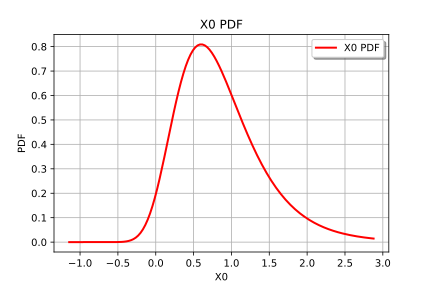

In [1]:
from __future__ import print_function
import openturns as ot

# the original distribution
distribution = ot.Gumbel(2.2, 0.6)
distribution.drawPDF()

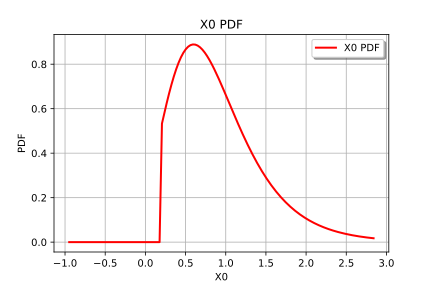

In [2]:
# truncate on the left
truncated = ot.TruncatedDistribution(distribution, 0.2, ot.TruncatedDistribution.LOWER)
truncated.drawPDF()

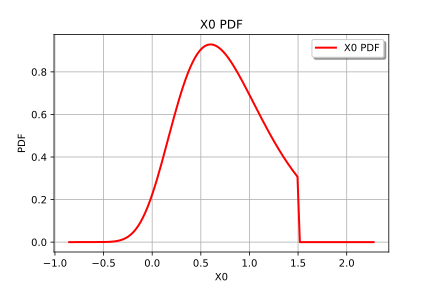

In [3]:
# truncate on the right
truncated = ot.TruncatedDistribution(distribution, 1.5, ot.TruncatedDistribution.UPPER)
truncated.drawPDF()

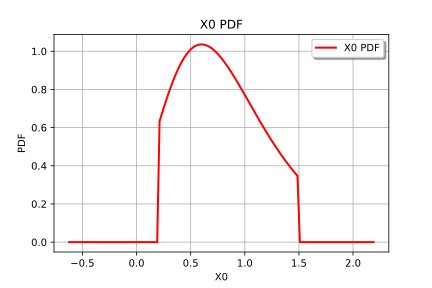

In [4]:
# truncated on both bounds
truncated = ot.TruncatedDistribution(distribution, 0.2, 1.5)
truncated.drawPDF()

In [5]:
# Define a multivariate distribution
dimension = 2
size = 70
sample = ot.Normal(dimension).getSample(size)
ks = ot.KernelSmoothing().build(sample)

In [6]:
# Truncate it between (-2;2)^n
bounds = ot.Interval([-2.0] * dimension, [2.0] * dimension)
truncatedKS = ot.Distribution(ot.TruncatedDistribution(ks, bounds))

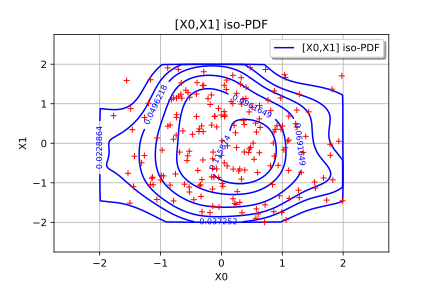

In [7]:
# Draw its PDF
graph = truncatedKS.drawPDF([-2.5] * dimension, [2.5] * dimension, [256] * dimension)
graph.add(ot.Cloud(truncatedKS.getSample(200)))
graph.setColors(["blue", "red"])
graph